In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import modified_mnist_dataloader_test, modified_mnist_dataloader_train, mnist_dataloader_train, multi_mnist_dataloader_test, multi_mnist_dataloader_train, multi_two_mnist_dataloader_train,  multi_two_mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [2]:
model_name = "multi_two_mnist/vae/langvein/inpainting"
config = get_model_config(model_name)

In [3]:
config["exp_params"]["batch_size"] = 1
dm = multi_mnist_dataloader_test(config, path=path)
gen = iter(dm)

/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
config["operator_params"]["size"] = 32

In [5]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

num_time_steps = 20

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out= []
    n_samples = 10
    for i in range(num_time_steps):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(num_time_steps):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach().numpy())
    return out

# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_pick_iteration(img):
    dm = multi_mnist_dataloader_train(config, path=path, shuffle=True)
    gen = iter(dm)
    config["exp_params"]["batch_size"] = 1
    out = []
    for i in range(num_time_steps):
        x, y = next(gen)
        x = x.to("cuda")
        adapt = make_adaptive_experiment(config)
        ri, A = adapt.random_pick_sample(x, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(img)
        if not out:
            out.append(torch.max(x_tilde).cpu().detach().numpy())
        else:
            out.append(max(out[-1], torch.max(x_tilde).cpu().detach().numpy()))
    return out

def baseline(img):
    return torch.max(img).cpu().detach().numpy()
    

In [6]:
num_runs = 25
val = {"ucb": [], "thomospon": [], "random": []}
for l in trange(num_runs):
    x, y = next(gen)
    x = x.to("cuda")
    ucb=  ucb_iteration(x)
    thomospon = thomospon_iteration(x)
    random = random_pick_iteration(x)
    max_x = baseline(x)
    val["ucb"].append([max_x - i for i in ucb])
    val["thomospon"].append([max_x - i for i in thomospon])
    val["random"].append([max_x - i for i in random])

  0%|          | 0/25 [00:00<?, ?it/s]/home/mingliang/anaconda3/envs/dgflowenv/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 25/25 [08:24<00:00, 20.20s/it]


In [7]:
ucb = np.array(val["ucb"]).mean(axis=0)
thomospon = np.array(val["thomospon"]).mean(axis=0)
random = np.array(val["random"]).mean(axis=0)
ucb_std = np.array(val["ucb"]).std(axis=0)
thomospon_std = np.array(val["thomospon"]).std(axis=0)
random_std = np.array(val["random"]).std(axis=0)

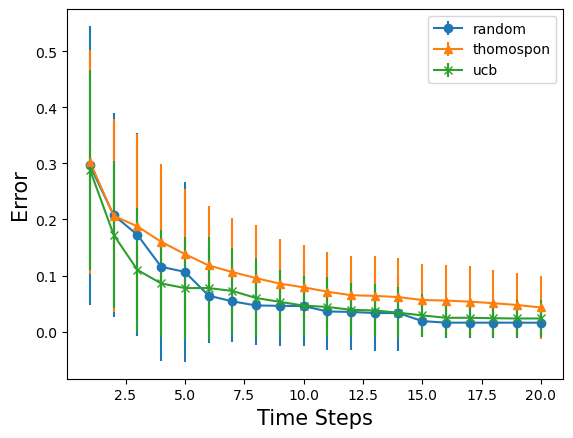

In [8]:
plt.xlabel('Time Steps', fontsize=15)
plt.ylabel('Error', fontsize=15)
time_steps = list(range(1, num_time_steps+1))
plt.errorbar(time_steps, random, yerr=random_std , fmt='-o')
plt.errorbar(time_steps, thomospon, yerr=thomospon_std, fmt='-^')
plt.errorbar(time_steps, ucb, yerr=ucb_std, fmt='-x')
plt.legend(["random", "thomospon", "ucb"])
plt.show()